In [124]:
import pandas as pd
import requests
import time
import dask
import intake
import dask.dataframe as dd

# Querying the Metadatabase

In [125]:
HOST = 'localhost'
PORT = 80
ENDPOINT_URI = f'http://{HOST}:{PORT}'

## Advanced Queries with GraphQL

With GraphQL you can query exactly what you want, rather than having to recieve the whole table from the database This is useful in cases where the whole table has many columns, but you are interested in just a subset of them.

The GraphQL endpoint is located at `/graphql` and recieves HTTP POST requests with the `query` parameter.

In [279]:
# Write our GraphQL query.
query = """
query {
    get_signal_datasets (limit: 3, where: {name: {contains: "AMC"}}) {
        signal_datasets {
            name
            dimensions
        }
    }
}
"""
# Query the API and get a JSON response
response = requests.post(f'{ENDPOINT_URI}/graphql', json={'query': query})
response.json()

{'data': {'get_signal_datasets': {'signal_datasets': [{'name': 'AMC_EFPS_CURRENT',
     'dimensions': ['time']},
    {'name': 'AMC_ERROR_FIELD_02', 'dimensions': ['time']},
    {'name': 'AMC_ERROR_FIELD_05', 'dimensions': ['time']}]}}}

In [272]:
# Write our GraphQL query.
query = """
query {
    get_signal_datasets (limit: 3, where: {name: {contains: "AMC"}}) {
        signal_datasets {
            name
            dimensions
            url
            get_shots (where: {shot_id: {lt: 11700}}){
                shots {
                    shot_id
                }
            }
        }
    }
}
"""
# Query the API and get a JSON response
response = requests.post(f'{ENDPOINT_URI}/graphql', json={'query': query})
response.json()

{'data': {'get_signal_datasets': {'signal_datasets': [{'name': 'AMC_EFPS_CURRENT',
     'dimensions': ['time'],
     'url': 's3://mast/AMC_EFPS_CURRENT.zarr',
     'get_shots': {'shots': [{'shot_id': 11695},
       {'shot_id': 11696},
       {'shot_id': 11697},
       {'shot_id': 11698},
       {'shot_id': 11699}]}},
    {'name': 'AMC_ERROR_FIELD_02',
     'dimensions': ['time'],
     'url': 's3://mast/AMC_ERROR_FIELD_02.zarr',
     'get_shots': {'shots': [{'shot_id': 11695},
       {'shot_id': 11696},
       {'shot_id': 11697},
       {'shot_id': 11698},
       {'shot_id': 11699}]}},
    {'name': 'AMC_ERROR_FIELD_05',
     'dimensions': ['time'],
     'url': 's3://mast/AMC_ERROR_FIELD_05.zarr',
     'get_shots': {'shots': [{'shot_id': 11695},
       {'shot_id': 11696},
       {'shot_id': 11697},
       {'shot_id': 11698},
       {'shot_id': 11699}]}}]}}}

GraphQL queries are paginated. You may access other entries by including the page metadata:

In [ ]:
from string import Template

def do_query(cursor: str = None):
    query = """
    query {
        get_signal_datasets (limit: 3, where: {name: {contains: "AMC"}}, ${cursor}) {
            signal_datasets {
                name
                dimensions
                get_shots (where: {shot_id: {lt: 11700}}){
                    shots {
                        shot_id
                    }
                }
            }
            page_meta {
              next_cursor
              total_items
              total_pages
            }
        }
    }
    """
    template = Template(query)
    query = template.substitute(cursor=f'cursor: "{cursor}"' if cursor is not None else "")
    return requests.post(f'{ENDPOINT_URI}/graphql', json={'query': query})


def iterate_responses():
    cursor = None
    while True:
        response = do_query(cursor)
        payload = response.json() 
        yield payload
        cursor = payload['data']['get_signal_datasets']['page_meta']['next_cursor']
        if cursor is None:
            return

responses = iterate_responses()
print(next(responses))
print(next(responses))
print(next(responses))

## Querying with the REST API

In [280]:
response = requests.get(f'{ENDPOINT_URI}/json/signals?size=2')
response.json()

{'items': [{'id': 1290912,
   'signal_dataset_id': 1151,
   'shot_id': 30471,
   'name': 'ESX_UPPER_INV_RADIUS/30471',
   'version': 0,
   'uuid': 'eef7d195-2cb0-42ab-9506-8416f18730c3',
   'url': 's3://mast/ESX_UPPER_INV_RADIUS.zarr/30471',
   'quality': 'Not Checked',
   'shape': [2]},
  {'id': 1290911,
   'signal_dataset_id': 1151,
   'shot_id': 30470,
   'name': 'ESX_UPPER_INV_RADIUS/30470',
   'version': 0,
   'uuid': '608062a5-00e0-4c36-a01c-383b900f266f',
   'url': 's3://mast/ESX_UPPER_INV_RADIUS.zarr/30470',
   'quality': 'Not Checked',
   'shape': [2]}],
 'total': 1290912,
 'page': 1,
 'size': 2,
 'pages': 645456,
 'column_metadata': {'id': 'int',
  'signal_dataset_id': 'int',
  'shot_id': 'int',
  'name': 'str',
  'version': 'int',
  'uuid': 'object',
  'url': 'str',
  'quality': 'object',
  'shape': 'object'}}

JSON API responses are paginated. You can use the option `page=xx` to access the next few items.

In [ ]:
response = requests.get(f'{ENDPOINT_URI}/json/signal_datasets?size=2&page=2')
response.json()

### Loading Paginated Responses with Dask

In [ ]:
response = requests.get(f'{ENDPOINT_URI}/json/shots')
num_pages = response.json()['pages']

@dask.delayed
def load_one_query(i): 
    response = requests.get(f'{ENDPOINT_URI}/json/shots?page={i}')
    response = response.json()
    return pd.DataFrame.from_dict(response['items']).astype(response['column_metadata'])

df = dd.from_delayed([load_one_query(i) for i in range(1, 5)])
df

In [ ]:
df.compute()

## Querying with File Streaming API

### Using Intake

In [ ]:
catalog = intake.open_catalog(f'{ENDPOINT_URI}/meta_catalog.yml')
gui = intake.interface.gui.GUI([catalog])
gui

Reading from the Intake catalog

In [ ]:
catalog.signal_datasets.read()

Direct access with the a known URI.

In [ ]:
pd.read_parquet(f'{ENDPOINT_URI}/files/shots')

Or even read the file in CSV format

In [ ]:
pd.read_csv(f'{ENDPOINT_URI}/files/shots?format=csv')

## Opening Remote Data Files

In [8]:
%%time
import zarr

handle = zarr.open_consolidated(f'{ENDPOINT_URI}/data/amc_test.zarr', mode='r')
# list(handle.groups())
keys = list(handle.groups())
keys = [k[0] for k in keys]
results ={}
for key in keys:
    g = handle[key]
    results[key] = dict(data=g["data"][:], error=g["error"][:], time=g["time"][:])

print(len(results))

1580
CPU times: user 4.22 s, sys: 795 ms, total: 5.02 s
Wall time: 9.59 s


In [307]:
import s3fs
import zarr
import numpy as np

file_name = 'amc_test.zarr'

s3 = s3fs.S3FileSystem(
    anon=True,
    use_ssl=False,
    client_kwargs={
        "endpoint_url": "http://localhost:9000"
    },
)
store = zarr.storage.FSStore(f'mast/{file_name}', fs=s3, exceptions=())
handle = zarr.open_consolidated(store)
arr = handle['28415']['data'][:]
assert not np.all(arr == 0)

arr = handle['28412']['data'][:]
assert not np.all(arr == 0)

print(arr)

AssertionError: 

In [232]:
%%time
import s3fs
import zarr
import numpy as np

file_name = 'rir.zarr'

s3 = s3fs.S3FileSystem(
    anon=True,
    use_ssl=False,
    client_kwargs={
        "endpoint_url": "http://localhost:9000"
    },
)

store = zarr.storage.FSStore(f'mast/{file_name}', fs=s3, check=False)
handle = zarr.open_consolidated(store)
keys = list(handle.groups())
keys = [k[0] for k in keys]
for key in keys:
    g = handle[key]
    results = dict(data=g["data"][:], time=g["time"][:])

print('Done!')

Done!
CPU times: user 59.2 s, sys: 7.62 s, total: 1min 6s
Wall time: 1min 9s


242
(184, 256, 320)


{'data': <zarr.core.Array '/28980/data' (184, 256, 320) uint16>,
 'time': <zarr.core.Array '/28980/time' (184,) float64>}

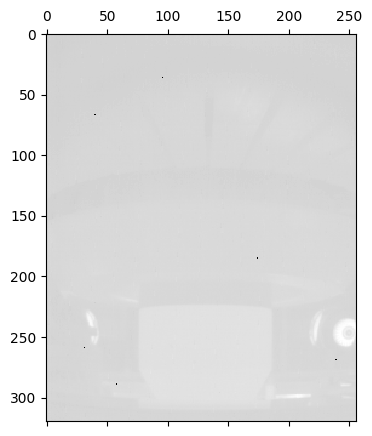

In [204]:
import zarr
import skimage
from skimage import filters
import matplotlib.pyplot as plt
handle = zarr.open('/home/ubuntu/projects/taps/data/rir.zarr')
groups = [v for k,v in handle.groups()]
groups = [g for g in groups if g['data'].shape[1] > 100]
print(len(groups))
data = groups[150]['data']
print(data.shape)
plt.matshow(data[0].T, cmap='gray')
dict(groups[150])